## 와인 데이터 분류

### 라이브러리 로드 및 EDA

In [32]:
import numpy as np # 벡터, 행렬 등 수치 연산을 수행하는 선형대수 라이브러리
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

In [33]:
# 레드 와인데이터셋 불러오기
red = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
# 화이트 와인데이터셋 불러오기
white = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

In [34]:
def boxplot_vis(data, target_name):
    plt.figure(figsize=(30, 30))
    for col_idx in range(len(data.columns)):
        # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(6, 2, col_idx+1)
        # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
        plt.boxplot(data[data.columns[col_idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
        # 그래프 타이틀: feature name
        plt.title("Feature" + "(" + target_name + "):" + data.columns[col_idx], fontsize = 20)
    plt.show()

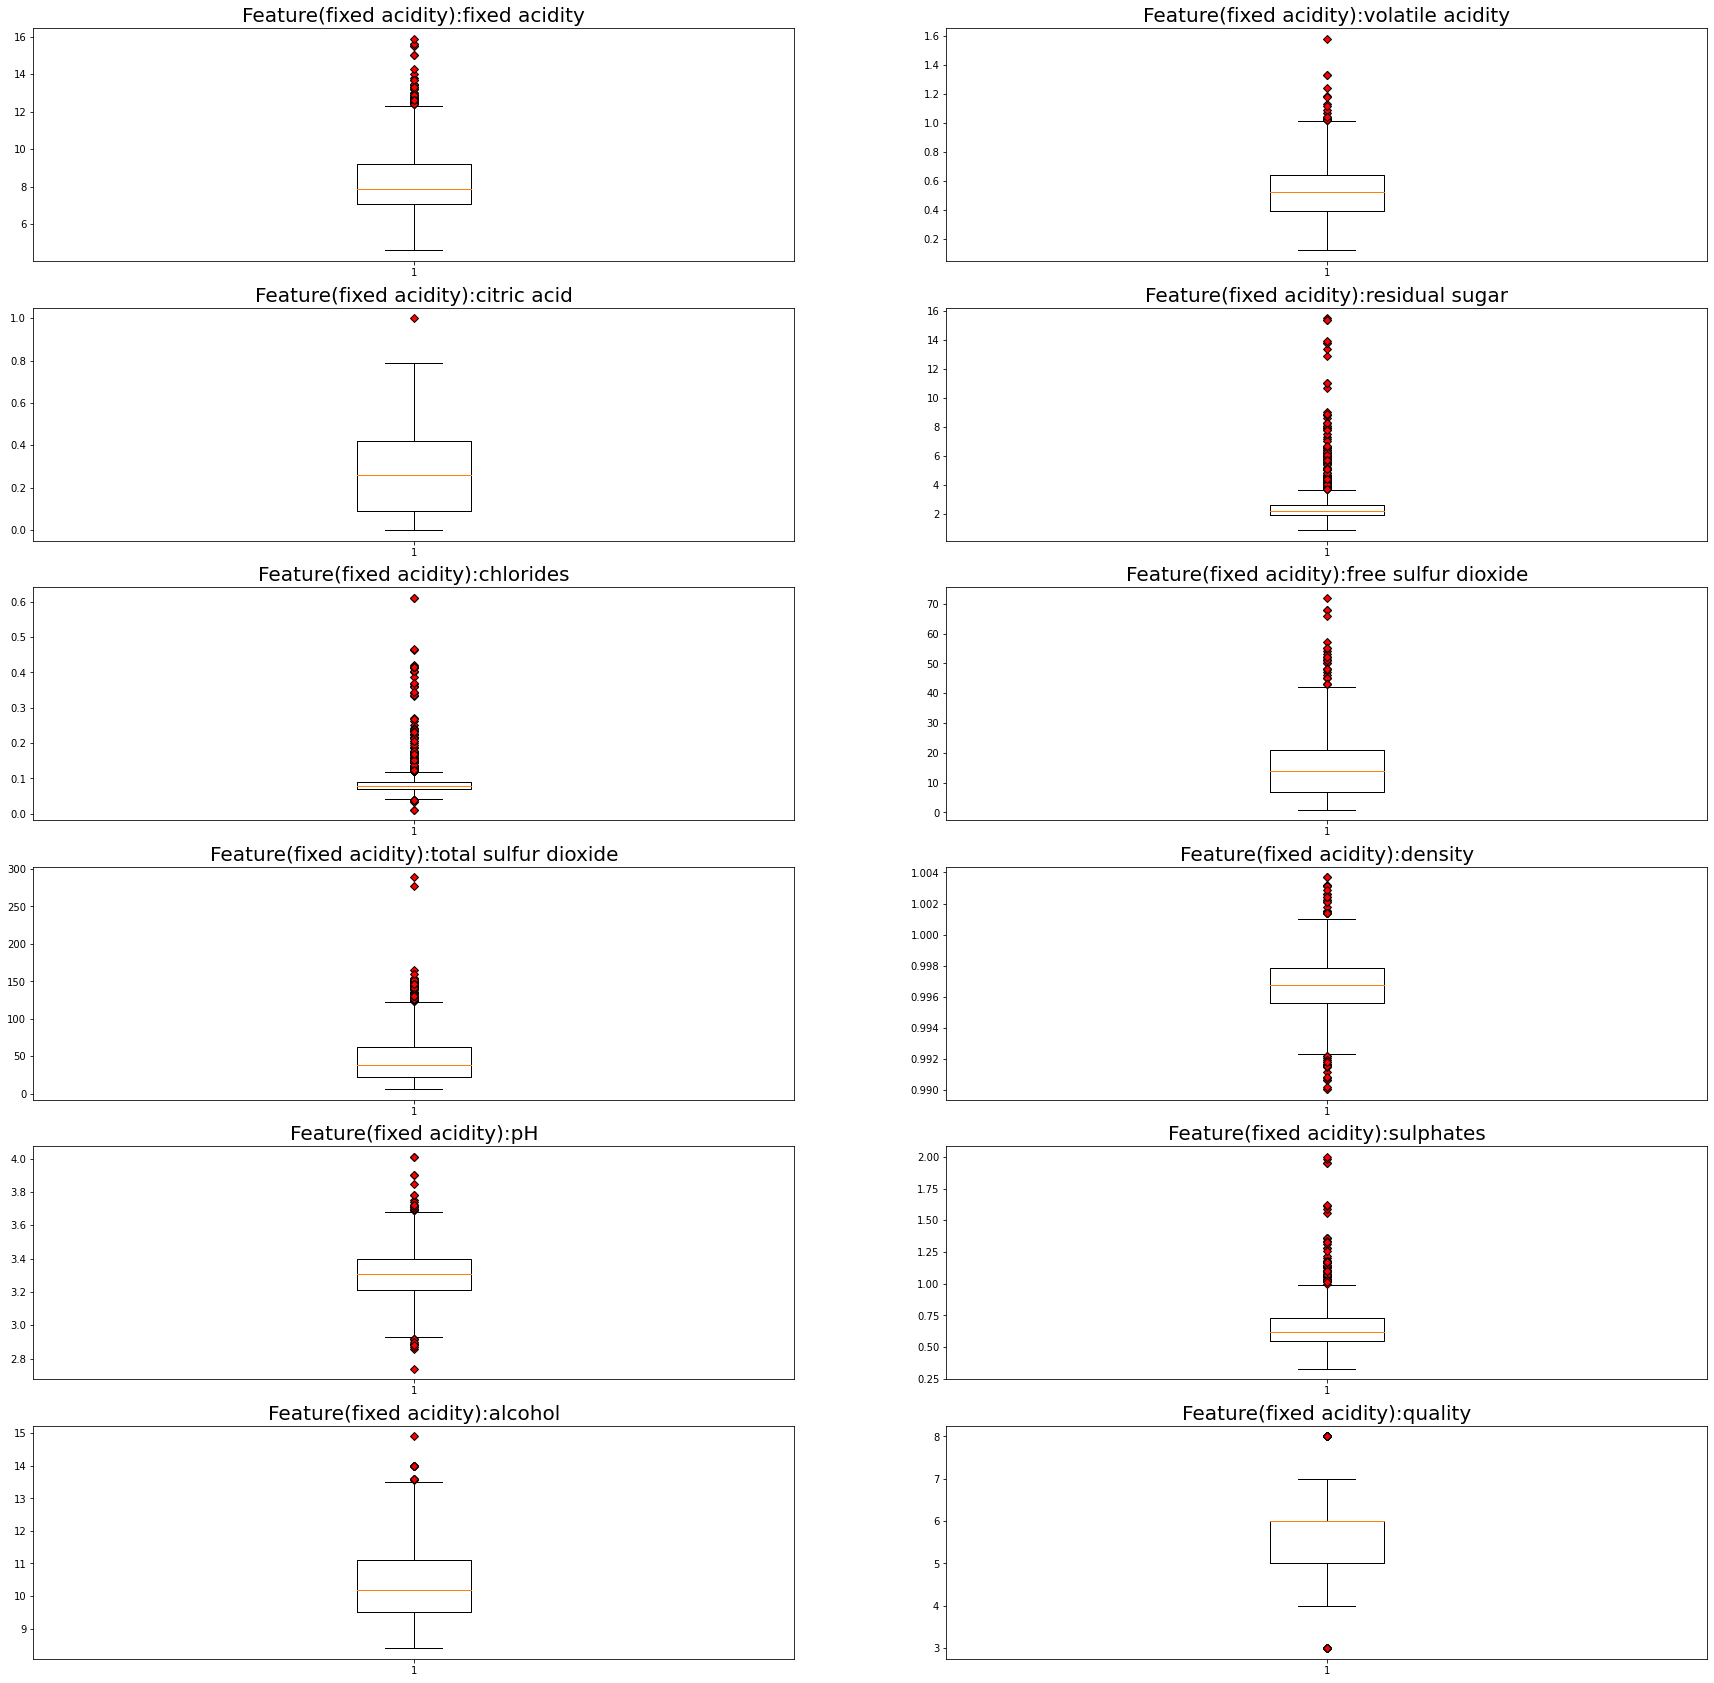

In [35]:
boxplot_vis(red,'fixed acidity')

In [36]:
def remove_outlier(input_data):
    q1 = input_data.quantile(0.25) # 제 1사분위수
    q3 = input_data.quantile(0.75) # 제 3사분위수
    iqr = q3 - q1 # IQR(Interquartile range) 계산
    minimum = q1 - (iqr * 1.5) # IQR 최솟값
    maximum = q3 + (iqr * 1.5) # IQR 최댓값
    # IQR 범위 내에 있는 데이터만 산출(IQR 범위 밖의 데이터는 이상치)
    df_removed_outlier = input_data[(minimum < input_data) & (input_data < maximum)]
    return df_removed_outlier

In [37]:
red_prep = remove_outlier(red)
red_prep['target'] = 0
red_prep.isnull().sum()

fixed acidity            49
volatile acidity         19
citric acid               1
residual sugar          155
chlorides               112
free sulfur dioxide      33
total sulfur dioxide     58
density                  45
pH                       35
sulphates                59
alcohol                  14
quality                  28
target                    0
dtype: int64

In [38]:
red_prep.dropna(axis = 0, how = 'any', inplace = True)
print(f"이상치 포함된 데이터 비율: {round((len(red) - len(red_prep))*100/len(red), 2)}%")

이상치 포함된 데이터 비율: 26.45%


In [39]:
white_prep = remove_outlier(white)
white_prep['target'] = 1
white_prep.isnull().sum()
white_prep.dropna(axis = 0, how = 'any', inplace = True)

In [40]:
df = pd.concat([red_prep, white_prep], axis = 0)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,0


In [41]:
df.target.value_counts(normalize=True)

1    0.765597
0    0.234403
Name: target, dtype: float64

In [42]:
# 표준 스케일러(평균 0, 분산 1)
scaler = StandardScaler()
# 설명변수 및 목표변수 분리
x = df[df.columns.difference(['target'])]
y = df['target']
# 설명변수 데이터 스케일링
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.3, random_state = 123)

### 함수 선언

1. 기본 - 하이퍼 파라미터 튜닝 X

In [43]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

2. 하이퍼 파라미터별 모델 성능 시각화 함수

In [44]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    plt.show()

3. 모델 최적화 함수: 학습할 트리 모델 개수 선정

In [45]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))

4. 모델 최적화 함수: 최대 깊이 선정

In [46]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

5. 모델 최적화 함수: 분리 노드의 최소 자료 수 선정

In [47]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

6. 모델 최적화 함수: 잎사귀 노드의 최소 자료 수 선정

In [48]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

### 최종 모델 사용

In [49]:
def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=123, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 123, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
    # 모델 저장
    model_path = 'C:/Users/liked/OneDrive/바탕 화면/데이콘/연습'
    model_filename = 'wine_classification_' + algorithm_name + '.pkl'
    with open(model_path + model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"최종 모델 저장 완료! 파일 경로: {model_path + model_filename}\n")
    
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어
    
    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                         x_test, y_test,
                         include_values = True,
                         display_labels = ['Red', 'White'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵
    # plt.savefig('../figure/' + algorithm_name + '_confusion_matrix.png') # 혼동행렬 자료 저장
    plt.show()
    
    # 변수 중요도 산출
    dt_importance = pd.DataFrame()
    dt_importance['Feature'] = feature_name # 설명변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    # 변수 중요도 시각화
    coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    plt.show()

In [50]:
# 랜덤포레스트 분류 알고리즘
algorithm = RFC
algorithm_name = 'rfc'

In [51]:
# 하이퍼 파리미터 튜닝 없이 기본 모델 학습 => 과적합 발생
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, x_train, y_train, x_test, y_test)

학습 데이터셋 정확도: 1.0
테스트 데이터셋 정확도: 0.999


모델 최적화 : 학습할 트리 개수 

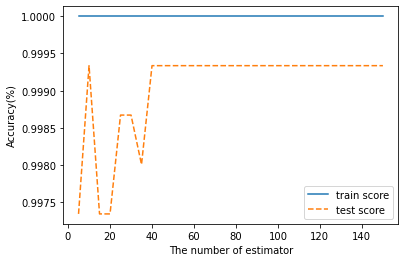

    n_estimators  TrainScore  TestScore
0              5         1.0     0.9973
1             10         1.0     0.9993
2             15         1.0     0.9973
3             20         1.0     0.9973
4             25         1.0     0.9987
5             30         1.0     0.9987
6             35         1.0     0.9980
7             40         1.0     0.9993
8             45         1.0     0.9993
9             50         1.0     0.9993
10            55         1.0     0.9993
11            60         1.0     0.9993
12            65         1.0     0.9993
13            70         1.0     0.9993
14            75         1.0     0.9993
15            80         1.0     0.9993
16            85         1.0     0.9993
17            90         1.0     0.9993
18            95         1.0     0.9993
19           100         1.0     0.9993
20           105         1.0     0.9993
21           110         1.0     0.9993
22           115         1.0     0.9993
23           120         1.0     0.9993


In [52]:
n_estimator_min = 1
n_estimator_max = 31
optimi_estimator(algorithm, algorithm_name, 
                 x_train, y_train, x_test, y_test, 
                 n_estimator_min, n_estimator_max)

- 트리 개수는 많을수록 과적합 방지에 유리합니다. 따라서 트리 개수가 많고 학습 데이터 기반 모델 정확도와 테스트 데이터 기반 모델 정확도의 차이가 적은 값으로 선정하는 것이 좋습니다.
- 트리 개수가 30개 일 때 테스트 데이터 기반 모델 정확도가 가장 높고, 트리 개수가 더 많아져도 성능에 차이가 없다는 점에, 최적의 트리 개수는 30으로 설정하겠습니다.

In [31]:
n_estimator = 30

모델 최적화 : 최대 깊이

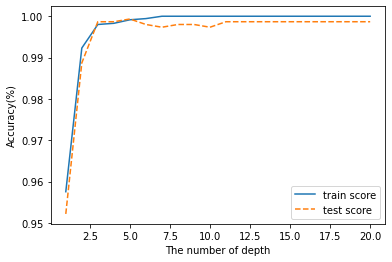

    depth  TrainScore  TestScore
0       1      0.9576     0.9522
1       2      0.9923     0.9887
2       3      0.9980     0.9987
3       4      0.9983     0.9987
4       5      0.9991     0.9993
5       6      0.9994     0.9980
6       7      1.0000     0.9973
7       8      1.0000     0.9980
8       9      1.0000     0.9980
9      10      1.0000     0.9973
10     11      1.0000     0.9987
11     12      1.0000     0.9987
12     13      1.0000     0.9987
13     14      1.0000     0.9987
14     15      1.0000     0.9987
15     16      1.0000     0.9987
16     17      1.0000     0.9987
17     18      1.0000     0.9987
18     19      1.0000     0.9987
19     20      1.0000     0.9987


In [53]:
depth_min = 1
depth_max = 21
optimi_maxdepth(algorithm, algorithm_name, 
                x_train, y_train, x_test, y_test, 
                depth_min, depth_max, n_estimator)

- 최대 깊이는 적을수록 과적합 방지에 유리합니다. 따라서 최대 깊이는 적고 학습 데이터 기반 모델 정확도와 테스트 데이터 기반 모델 정확도의 차이가 적은 값으로 선정하는 것이 좋습니다. 
- 테스트 데이터 기반 모델 정확도가 점차 증가하다가 감소하기 시작하는 구간으로, 최대 깊이 6을 최적의 값으로 선정

In [54]:
n_depth = 6

모델 최적화: 분리 노드의 최소 자료 수

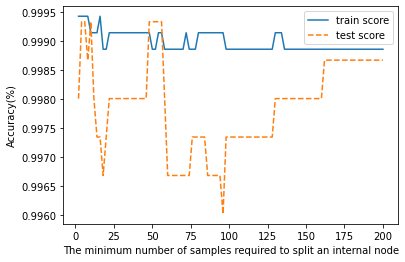

    min_samples_split  TrainScore  TestScore
0                   2      0.9994     0.9980
1                   4      0.9994     0.9993
2                   6      0.9994     0.9993
3                   8      0.9994     0.9987
4                  10      0.9991     0.9993
5                  12      0.9991     0.9980
6                  14      0.9991     0.9973
7                  16      0.9994     0.9973
8                  18      0.9989     0.9967
9                  20      0.9989     0.9973
10                 22      0.9991     0.9980
11                 24      0.9991     0.9980
12                 26      0.9991     0.9980
13                 28      0.9991     0.9980
14                 30      0.9991     0.9980
15                 32      0.9991     0.9980
16                 34      0.9991     0.9980
17                 36      0.9991     0.9980
18                 38      0.9991     0.9980
19                 40      0.9991     0.9980
20                 42      0.9991     0.9980
21        

In [56]:
n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 x_train, y_train, x_test, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

- 분리 노드의 최소 자료 수는 많을수록 과적합 방지에 유리합니다. 
- 따라서 분리 노드의 최소 자료 수는 많되 학습 데이터 기반 모델 정확도와 테스트 데이터 기반 모델 정확도의 차이가 적은 값으로 선정하는 것이 좋습니다.

In [61]:
n_split = 66

모델 최적화: 잎사귀 노드의 최소 자료 수

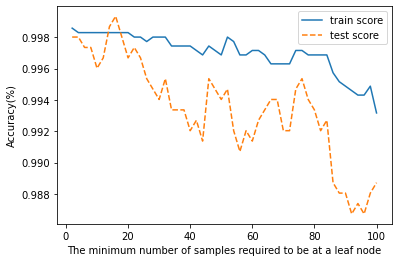

    min_samples_leaf  TrainScore  TestScore
0                  2      0.9986     0.9980
1                  4      0.9983     0.9980
2                  6      0.9983     0.9973
3                  8      0.9983     0.9973
4                 10      0.9983     0.9960
5                 12      0.9983     0.9967
6                 14      0.9983     0.9987
7                 16      0.9983     0.9993
8                 18      0.9983     0.9980
9                 20      0.9983     0.9967
10                22      0.9980     0.9973
11                24      0.9980     0.9967
12                26      0.9977     0.9954
13                28      0.9980     0.9947
14                30      0.9980     0.9940
15                32      0.9980     0.9954
16                34      0.9974     0.9934
17                36      0.9974     0.9934
18                38      0.9974     0.9934
19                40      0.9974     0.9920
20                42      0.9972     0.9927
21                44      0.9969

In [62]:
n_leaf_min = 1
n_leaf_max = 51
optimi_minleaf(algorithm, algorithm_name, 
               x_train, y_train, x_test, y_test, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

- 잎사귀 노드의 최소 자료 수는 많을수록 과적합 방지에 유리합니다. 
- 따라서 잎사귀 노드의 최소 자료 수는 많되 학습 데이터 기반 모델 정확도와 테스트 데이터 기반 모델 정확도의 차이가 적은 값으로 선정하는 것이 좋습니다. 

In [64]:
n_leaf = 20

최종 모델 저장 완료! 파일 경로: C:/Users/liked/OneDrive/바탕 화면/데이콘/연습wine_classification_rfc.pkl

Accuracy: 0.997
Precision: 0.997
Recall: 0.999
F1-score: 0.998


<Figure size 2160x2160 with 0 Axes>

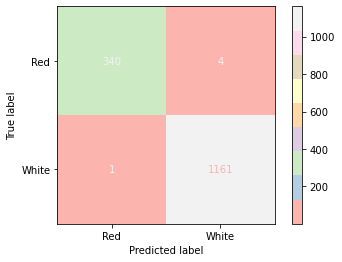

                 Feature  Importance
10  total sulfur dioxide       0.383
1              chlorides       0.262
11      volatile acidity       0.105
8         residual sugar       0.088
4          fixed acidity       0.049
5    free sulfur dioxide       0.041
3                density       0.038
9              sulphates       0.018
2            citric acid       0.012
6                     pH       0.005
7                quality       0.000
0                alcohol       0.000


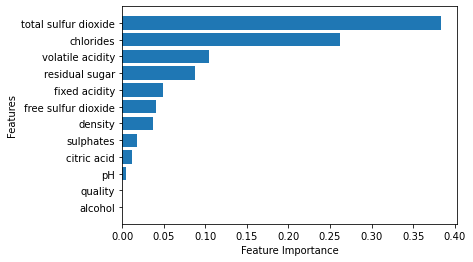

In [65]:
model_final(algorithm, algorithm_name, feature_name,
            x_train, y_train, x_test, y_test,
            n_estimator, n_depth, n_split, n_leaf)

- 최종 모델 확인 결과 total sulfur dioxide(총 이산화황), chlorides(염화물), volatile acidity(휘발성산)이 와인 분류시 중요도가 가장 높은 것을 확인
- 모델의 정확도는 99.7%, f1 score는 0.998로 상당히 우수한 분류 모델